In [53]:
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import NLLLoss, BCEWithLogitsLoss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve
from torch_geometric.loader import DataLoader
import copy
from torch_geometric.utils import to_dense_adj

Setting seeds for reproducibility

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
path = "../../graphs/tx_graph/"
file = path + "tx_transaction_graph_timestamp_1.pkl"
with open(file, "rb") as f:
    graph = pickle.load(f)

In [5]:
def feature_matrix(graph, as_pandas=False):
    #Returns a feature matrix of an input graph as a numpy array (default) or pandas df (if specified)
    attr_dict = dict(graph.nodes(data=True))
    X = pd.DataFrame.from_dict(attr_dict, orient='index')
    if as_pandas:
        return X
    return X.to_numpy()

# DATA PIPELINE
We noticed that some of the features are way bigger in magnitude than others, hence we will normalize.\
Some values are also na so we will inject them with the column mean. 

In [3]:
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import MinMaxScaler

def graph_to_data(graph, standardize=True, minmax=False):
    #Takes graph data and turns it into an appropriate torch_geometric data instance
    
    attrs = list(next(iter(graph.nodes(data=True)))[1].keys())
    attrs.remove("class")

    data = from_networkx(graph, group_node_attrs=attrs)
    
    column_mean = data.x.nanmean(dim=0)
    inds = torch.where(torch.isnan(data.x))
    data.x[inds] = column_mean[inds[1]] #input means where there are nan values

    if standardize and minmax:
        raise Exception("Cannot standardize and minmax at the same time")
    
    if standardize:
        mean = data.x.mean(dim=0)
        std = data.x.std(dim=0) + 1e-6
        data.x = (data.x - mean) / std
    
    if minmax:
        scaler = MinMaxScaler()
        data.x = torch.tensor(scaler.fit_transform(data.x), dtype=torch.float32)

    labels = [graph.nodes[n]["class"] for n in graph.nodes()]
    data.y = torch.tensor(labels)
    return data

Creating a dataset where each graph is standardized individually

In [7]:
#This takes around 35 seconds
dataset = []
for i in range(1, 50):
    file = path + f"../../graphs/tx_graph/tx_transaction_graph_timestamp_{i}.pkl"
    with open(file, "rb") as f:
        graph = pickle.load(f)
        dataset.append(graph_to_data(graph))

with open("individually_standardized_graphs", "wb") as f:
    pickle.dump(dataset, f)

In [8]:


with open("individually_standardized_graphs", "rb") as f:
    dataset = pickle.load(f)

train_dataset = dataset[:30]
val_dataset = dataset[30:40]
test_dataset = dataset[40:]

train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset)
test_loader = DataLoader(test_dataset)

Creating a dataset where the standardizer is trained on the whole train data

In [9]:
from sklearn.preprocessing import StandardScaler

raw_dataset = []
for i in range(1, 50):
    file = path + f"tx_transaction_graph_timestamp_{i}.pkl"
    with open(file, "rb") as f:
        graph = pickle.load(f)
        raw_dataset.append(graph_to_data(graph, False, False))

with open("raw_graphs", "wb") as f:
    pickle.dump(raw_dataset, f)


In [10]:
with open("raw_graphs", "rb") as f:
    raw_dataset = pickle.load(f)

train_tensor = torch.cat([g.x for g in raw_dataset[:30]])

standard_scaler = StandardScaler()

standard_scaler.fit(train_tensor)

for graph in raw_dataset:
    graph.x = torch.Tensor(standard_scaler.transform(graph.x))

with open("batch_standardized_graphs", "wb") as f:
    pickle.dump(raw_dataset, f)

In [4]:
def load_data(data_type):
    #Function that takes a data_type string argument and returns appropriate train, validation, and test data loaders.
    torch.manual_seed(42)
    
    if data_type == "raw":
        fname = "raw_graphs"
    elif data_type == "batch":
        fname = "batch_standardized_graphs"
    elif data_type == "individual":
        fname = "individually_standardized_graphs"
    else:
        raise Exception("Invalid argument, supply one of the following [`raw`, `batch`, `individual`]")

    with open(fname, "rb") as f:
        dataset = pickle.load(f)

    train_dataset = dataset[:30]
    val_dataset = dataset[30:40]
    test_dataset = dataset[40:]

    train_loader = DataLoader(train_dataset, shuffle=True)
    val_loader = DataLoader(val_dataset)
    test_loader = DataLoader(test_dataset)

    return train_loader, val_loader, test_loader

# Finding out training labels ratio

In [ ]:
#This code was used to initially weigh the loss function to account for class imbalance
from collections import Counter
all_y = []
for dataset in train_dataset:
    all_y.extend(dataset.y.tolist())

counter = Counter(all_y)
counter.items()
illicit = counter[1.0]
licit = counter[2.0]

illicit_ratio = illicit / (illicit + licit)
licit_ratio = licit / (illicit + licit)

print(illicit_ratio, licit_ratio)

# Defining the simple Graph Convolutional NN

In [6]:
from torch_geometric.nn import GCNConv

#Initial GCNConv based convolutional NN
class GCN(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, ):
        super(GCN, self).__init__()

        #Initialize convolutional layers
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            if num_layers == 1:
                self.convs.append(GCNConv(input_dim, output_dim))
            elif i == 0:
                self.convs.append(GCNConv(input_dim, hidden_dim))
            elif i == (num_layers - 1):
                self.convs.append(GCNConv(hidden_dim, output_dim))
            else:
                self.convs.append(GCNConv(hidden_dim, hidden_dim))

        #Layer normalization, softmax, and dropout initialization
        self.lns = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)])
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout

    
    def forward(self, x, adj_t):
        #Performs a forward pass: convolutions and layer normalization for all passes but the last, where layer normalization is ommited.
        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            if i < len(self.lns):
                x = self.lns[i](x)
                x = torch.nn.functional.relu(x)
                x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
        return self.softmax(x)
        # return(x)

In [7]:
def train(model, loader, optimizer, loss_fn):
    #Takes model, data loader, optimized, and loss function. Returns average loss.

    #Set model to train mode and initialize parameters
    model.train()
    total_loss = 0
    count = 0

    #Batch wise training
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        y = batch.y

        mask = y != 3

        if mask.sum() == 0:   # skip empty batch
            continue

        #Need to remap this to work with nll loss. Now 0 is illicit and 1 is licit.
        y_remapped = (y[mask] - 1).long()
        
        loss = loss_fn(out[mask], y_remapped)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1

    return total_loss / max(count, 1)

F1 score can take an argument "pos_label" with which we set the positive label. In our case, illicit cases count as positives.

In [59]:
@torch.no_grad()
def test(model, loader, loss_fn, bincount=False, full_report=False):
    #Function that takes a model, data loader, and the loss function along with two defaulta parameters. Evaluates the model on the test data loader that is provided.
    #Option to get a full detailed F1 score report can be obtained by using full_report=True

    #Setting the model in evaluation mode as well as initializing parameters.
    model.eval()
    total_loss = 0
    count = 0

    all_predictions = []
    all_y = []

    all_probs = []

    for batch in loader:

        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        y = batch.y
        
        mask = y != 3

        if mask.sum() == 0:   # skip empty batch
            continue

        y_remapped = (y[mask] - 1).long()

        masked_out = out[mask]
        predicted_classes = masked_out.argmax(dim=1)

        all_probs.extend(masked_out[:, 0].cpu())

        if bincount:
            print(predicted_classes.bincount())
        
        all_predictions.extend(predicted_classes.cpu())
        all_y.extend(y_remapped.cpu())

        total_loss += loss_fn(masked_out, y_remapped).item()
        count += 1
    
    if full_report:
        return (precision_score(all_y, all_predictions, pos_label=0),
                recall_score(all_y, all_predictions, pos_label=0),
                f1_score(all_y, all_predictions, pos_label=0),
                f1_score(all_y, all_predictions, average="macro"),
                f1_score(all_y, all_predictions, average="micro"),
                roc_auc_score(all_y, all_probs),
                total_loss/count,
                )
        

    return f1_score(all_y, all_predictions, pos_label=0), total_loss/count

In [ ]:
def train_model(model_class, args, train_loader, val_loader, test_loader):
    #Function that takes the model class, model args, train loader, validation loader and test loader. Then it trains and returns the model.
    #Used to avoid constant rewriting of training code     
    np.random.seed(42)
    torch.manual_seed(42)

    model = model_class(
    args["input_dim"],
    args["hidden_dim"],
    args["output_dim"],
    args["num_layers"],
    args["conv_layer"],
    args["nonlinearity"],
    args["dropout"],
    args["k_hops"])

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"], weight_decay=args["weight_decay"])
    loss_fn = NLLLoss()
    test_losses = []
    val_losses = []

    for epoch in range(args["epochs"]):
        train_result = train(model, train_loader, optimizer, loss_fn)
        val_f1, val_loss = test(model, val_loader, loss_fn)

        test_losses.append(train_result)
        val_losses.append(val_loss)
        if epoch%10 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_result} | Validation f1: {val_f1} | Validation loss: {val_loss}")
    
    sns.lineplot(x=range(len(test_losses)), y=test_losses)
    sns.lineplot(x=range(len(test_losses)), y=val_losses)
    
    return model

# LEARNING ALGORITHM PARAMETERS

In [9]:
args = {
      'device': device,
      'num_layers': 3,
      'hidden_dim': 256,
      'dropout': 0.5,
      'lr': 0.0001,
      'epochs': 100,
  }

# MODEL INSTANTIATION

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

#Create the model
model = GCN(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = NLLLoss()

train_loader, val_loader, test_loader = load_data("batch") #"batch", "individual", or "raw" to get their corresponding data loaders 

In [47]:
test_losses = []
val_losses = []

for epoch in range(args["epochs"]):
    train_result = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    test_losses.append(train_result)
    val_losses.append(val_loss)
    
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_result} | Validation f1: {val_f1} | Validation loss: {val_loss}")

Epoch: 0 | Train loss: 0.7684923628966014 | Validation f1: 0.0 | Validation loss: 0.3746154375374317
Epoch: 10 | Train loss: 0.2588782362639904 | Validation f1: 0.5129118432769367 | Validation loss: 0.26305423080921175
Epoch: 20 | Train loss: 0.222340506563584 | Validation f1: 0.5857988165680473 | Validation loss: 0.254894894361496
Epoch: 30 | Train loss: 0.20296214185655118 | Validation f1: 0.5830828681837699 | Validation loss: 0.24552337676286698
Epoch: 40 | Train loss: 0.1877137955278158 | Validation f1: 0.5784716516023007 | Validation loss: 0.2488032579421997
Epoch: 50 | Train loss: 0.1783167311300834 | Validation f1: 0.5960502692998204 | Validation loss: 0.23260284066200257
Epoch: 60 | Train loss: 0.17145549828807513 | Validation f1: 0.6056143580303728 | Validation loss: 0.22540684491395951
Epoch: 70 | Train loss: 0.16451315879821776 | Validation f1: 0.6164874551971327 | Validation loss: 0.22314439117908477
Epoch: 80 | Train loss: 0.1567621429761251 | Validation f1: 0.619546247818

<Axes: >

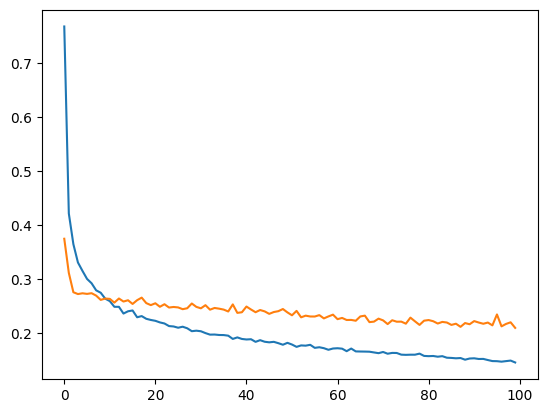

In [48]:
sns.lineplot(x=range(len(test_losses)), y=test_losses)
sns.lineplot(x=range(len(test_losses)), y=val_losses)


In [49]:
test(model, test_loader, loss_fn, True)

tensor([ 111, 1021], device='cuda:0')
tensor([ 141, 2013], device='cuda:0')
tensor([  11, 1359], device='cuda:0')
tensor([  18, 1573], device='cuda:0')
tensor([  26, 1195], device='cuda:0')
tensor([ 13, 699], device='cuda:0')
tensor([  4, 842], device='cuda:0')
tensor([  3, 468], device='cuda:0')
tensor([  0, 476], device='cuda:0')


(0.3595769682726204, 0.18570315589507422)

In [35]:
torch.save(model.state_dict(), "GCN_model_weights.pth")

# Finding the best GCN (without grid search for now)

In [63]:
import copy

train_loader, val_loader, test_loader = load_data("batch")

np.random.seed(42)
torch.manual_seed(42)
model = GCN(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = NLLLoss()
# weight=torch.tensor([licit_ratio, illicit_ratio]).to(device)
best_f1 = -np.inf
best_model = None

for epoch in range(args["epochs"]):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    if val_f1 > best_f1:
        best_f1= val_f1
        best_model = copy.deepcopy(model)
        print(f"New best model!  F1: {val_f1}, loss: {val_loss}")

New best model!  F1: 0.0, loss: 0.3903261199593544
New best model!  F1: 0.04508566275924256, loss: 0.29470568150281906
New best model!  F1: 0.38367844092570036, loss: 0.2730802372097969
New best model!  F1: 0.4204609331084879, loss: 0.26937720775604246
New best model!  F1: 0.4600896860986547, loss: 0.2794589281082153
New best model!  F1: 0.46160754378087115, loss: 0.27498871088027954
New best model!  F1: 0.4616822429906542, loss: 0.2670536622405052
New best model!  F1: 0.4755671902268761, loss: 0.2720039561390877
New best model!  F1: 0.4816849816849817, loss: 0.2630210667848587
New best model!  F1: 0.5144775493075955, loss: 0.27040141969919207
New best model!  F1: 0.5299710624224886, loss: 0.26962410658597946
New best model!  F1: 0.5349048050770625, loss: 0.2566190451383591
New best model!  F1: 0.5417362270450752, loss: 0.2646128416061401
New best model!  F1: 0.5676483141271874, loss: 0.26131670773029325
New best model!  F1: 0.5728070175438597, loss: 0.2566557601094246
New best model! 

# The results of the best baseline GCN model
(0.38717067583046966, 0.19030466261837217)

In [64]:
test(best_model, test_loader, loss_fn, True)

tensor([ 109, 1023], device='cuda:0')
tensor([ 154, 2000], device='cuda:0')
tensor([  14, 1356], device='cuda:0')
tensor([  22, 1569], device='cuda:0')
tensor([  28, 1193], device='cuda:0')
tensor([ 12, 700], device='cuda:0')
tensor([  5, 841], device='cuda:0')
tensor([  3, 468], device='cuda:0')
tensor([  2, 474], device='cuda:0')


(0.38717067583046966, 0.19030466261837217)

Saving the model weights for reproducibility

In [108]:
torch.save(best_model.state_dict(), "GCN_model_weights.pth")

In [14]:
from itertools import product

parameters = {
      'num_layers': [1, 3, 5],
      'hidden_dim': [128, 256, 512],
      'dropout': [0.1, 0.3, 0.5],
      'lr': [0.0001, 0.001, 0.01, 0.1],
  }

print(len(list(product(*parameters.values()))))


108


# GRID SEARCH CODE

In [ ]:
def find_best_model(model_class, parameters, epochs, device, train_loader, val_loader):
    #Takes a model class, parameters, epochs, device, train loader and validation loader. It performs a grid search and returns the best model
    #from those parameters.
    best_f1_model = None
    best_loss_model = None

    best_f1 = -np.inf
    best_loss = np.inf

    for num_layers, hidden_dim, dropout, lr in list(product(*parameters.values())):

        np.random.seed(42)
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)

        model = model_class(183, #hardcoded for now
                            hidden_dim,
                            2,   #hardcoded for now
                            num_layers,
                            dropout
                            ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = NLLLoss()
        for epoch in range(epochs):
            train_loss = train(model, train_loader, optimizer, loss_fn)
            val_f1, val_loss = test(model, val_loader, loss_fn)

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_f1_model = copy.deepcopy(model)
                print("Found new best f1 model: Args: ", num_layers, hidden_dim, dropout, lr, epoch, "F1: ", val_f1)

            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_model = copy.deepcopy(model)
                print("Found new best loss model: Args: ", num_layers, hidden_dim, dropout, lr, epoch, "Loss: ", val_loss)

    return best_f1_model, best_loss_model

In [17]:
train_loader, val_loader, test_loader = load_data("batch")
best_f1_model, best_loss_model = find_best_model(GCN, parameters, 100, device, train_loader, val_loader)

Found new best f1 model: Args:  1 128 0.1 0.0001 0 F1:  0.15336039693279205
Found new best loss model: Args:  1 128 0.1 0.0001 0 Loss:  0.5053310588002204
Found new best f1 model: Args:  1 128 0.1 0.0001 1 F1:  0.204655248133509
Found new best loss model: Args:  1 128 0.1 0.0001 1 Loss:  0.474496091902256
Found new best f1 model: Args:  1 128 0.1 0.0001 2 F1:  0.28010247651579845
Found new best loss model: Args:  1 128 0.1 0.0001 2 Loss:  0.4362235859036446
Found new best f1 model: Args:  1 128 0.1 0.0001 3 F1:  0.34103827207275483
Found new best loss model: Args:  1 128 0.1 0.0001 3 Loss:  0.4341555953025818
Found new best f1 model: Args:  1 128 0.1 0.0001 4 F1:  0.3553903345724907
Found new best loss model: Args:  1 128 0.1 0.0001 4 Loss:  0.4223642572760582
Found new best f1 model: Args:  1 128 0.1 0.0001 5 F1:  0.37380530973451326
Found new best loss model: Args:  1 128 0.1 0.0001 5 Loss:  0.41722259372472764
Found new best f1 model: Args:  1 128 0.1 0.0001 6 F1:  0.381637547105173

In [ ]:
#Saving the best GCN models
torch.save(best_f1_model.state_dict(), "GCN_best_f1_model_weights.pth")
torch.save(best_loss_model.state_dict(), "GCN_best_loss_model_weights.pth")

In [ ]:
precision, recall, f1, macro, micro, roc_auc, loss = test(best_f1_model, test_loader, loss_fn, True, True)
print(f"precision: {precision}, recall: {recall}, F1: {f1}, macro: {macro}, micro: {micro}, roc_auc: {roc_auc}")

In [ ]:
train_loader, val_loader, test_loader = load_data("batch")
m = GCN(183, 512, 2, 3, 0.5)
m.load_state_dict(torch.load("GCN_best_f1_model_weights.pth", weights_only=True))
m.to(device)

loss_fn = NLLLoss()
test(m, test_loader, loss_fn)

# Defining GraphSAGE

In [21]:
from torch_geometric.nn import SAGEConv
#Initial SAGE based GNN.
class SAGE(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, ):
        super(SAGE, self).__init__()

        #Initialize SAGEConv layers
        self.convs = torch.nn.ModuleList()   
        for i in range(num_layers):
            if num_layers == 1:
                self.convs.append(SAGEConv(input_dim, output_dim))
            elif i == 0:
                self.convs.append(SAGEConv(input_dim, hidden_dim))
            elif i == (num_layers - 1):
                self.convs.append(SAGEConv(hidden_dim, output_dim))
            else:
                self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        #Initializes layer normalization, softmax, and dropout
        self.lns = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)])
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout

    #Forward pass
    def forward(self, x, adj_t):
        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            if i < len(self.lns):
                x = self.lns[i](x)
                x = torch.nn.functional.relu(x)
                x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
        return self.softmax(x)

In [24]:
model = SAGE(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = NLLLoss()

train_loader, val_loader, test_loader = load_data("batch")

In [ ]:
test_losses = []
val_losses = []


for epoch in range(50):
    train_result = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    test_losses.append(train_result)
    val_losses.append(val_loss)
    
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_result} | Validation f1: {val_f1} | Validation loss: {val_loss}")

<Axes: >

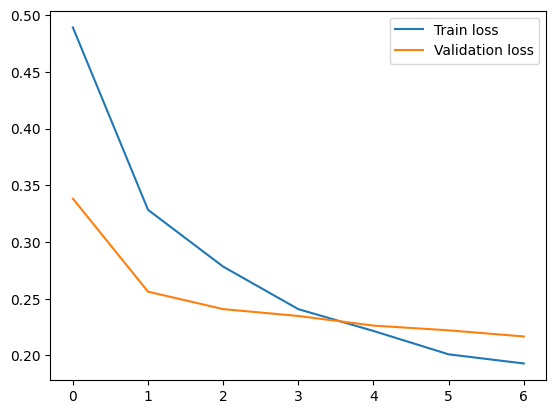

In [26]:
sns.lineplot(x=range(len(test_losses)), y=test_losses, label="Train loss")
sns.lineplot(x=range(len(test_losses)), y=val_losses, label="Validation loss")


In [27]:
test(model, test_loader, loss_fn, True, True)

tensor([ 109, 1023], device='cuda:0')
tensor([ 252, 1902], device='cuda:0')
tensor([  10, 1360], device='cuda:0')
tensor([ 272, 1319], device='cuda:0')
tensor([  57, 1164], device='cuda:0')
tensor([ 19, 693], device='cuda:0')
tensor([ 17, 829], device='cuda:0')
tensor([  5, 466], device='cuda:0')
tensor([  6, 470], device='cuda:0')


(0.29852744310575635,
 0.4255725190839695,
 0.35090479937057434,
 0.6533640462716326,
 0.9172766469467563,
 0.23601637449529436)

# Grid search on SAGE

In [ ]:
train_loader, val_loader, test_loader = load_data("batch")
best_f1_sage_model, best_loss_sage_model = find_best_model(SAGE, parameters, 100, device, train_loader, val_loader)

In [ ]:
import copy

train_loader, val_loader, test_loader = load_data("batch")

np.random.seed(42)
torch.manual_seed(42)
model = SAGE(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = NLLLoss(weight=torch.tensor([licit_ratio, illicit_ratio]).to(device))

best_loss = np.inf
best_model = None
best_model_epoch = None

for epoch in range(args["epochs"]):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        print(f"New best model!  F1: {val_f1}, loss: {val_loss}")

# The results of the best baseline SAGE model
0.5547619047619048

In [44]:
precision, recall, f1, macro, micro, loss = test(best_f1_sage_model, test_loader, loss_fn, True, True)
print(f"precision: {precision}, recall: {recall}, F1: {f1}, macro: {macro}, micro: {micro}")

tensor([  96, 1036], device='cuda:0')
tensor([ 173, 1981], device='cuda:0')
tensor([  19, 1351], device='cuda:0')
tensor([   8, 1583], device='cuda:0')
tensor([   7, 1214], device='cuda:0')
tensor([  5, 707], device='cuda:0')
tensor([  7, 839], device='cuda:0')
tensor([  0, 471], device='cuda:0')
tensor([  1, 475], device='cuda:0')
precision: 0.7373417721518988, recall: 0.4446564885496183, F1: 0.5547619047619048, macro: 0.7675934510724629, micro: 0.9624987466158629


In [ ]:
#Saving the best models for reproducivility
torch.save(best_f1_sage_model.state_dict(), "GCN_best_f1_sage_model_weights.pth")
torch.save(best_loss_sage_model.state_dict(), "GCN_best_loss_sage_model_weights.pth")

In [51]:
train_loader, val_loader, test_loader = load_data("batch")
m = SAGE(183, 128, 2, 5, 0.5)
m.load_state_dict(torch.load("GCN_best_f1_sage_model_weights.pth", weights_only=True))
m.to(device)

loss_fn = NLLLoss()
test(m, test_loader, loss_fn, full_report=True)

(0.7373417721518988,
 0.4446564885496183,
 0.5547619047619048,
 0.7675934510724629,
 0.9624987466158629,
 0.862826057810473,
 0.2715915497392416)

In [9]:
def n_hop_neighbourhood(A, n):
    #Takes a matrix A and an integer n returns an adjacency matrix corresponding to nodes n hops away
    n_hop = ((torch.linalg.matrix_power(A, n) > 0) & (A == 0)).float()
    return n_hop

A = torch.tensor([
    [0, 1, 0, 0, 0],  # 0 connected to 1
    [1, 0, 1, 0, 1],  # 1 connected to 0,2,4
    [0, 1, 0, 1, 0],  # 2 connected to 1,3
    [0, 0, 1, 0, 0],  # 3 connected to 2
    [0, 1, 0, 0, 0],  # 4 connected to 1
],)

n_hop_neighbourhood(A, 3)

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])

# SAGE with neighbourhood aggregation after embedding

In [10]:
from torch_geometric.nn import SAGEConv
#Improves SAGE style GNN with neighborhood aggregation
class SAGE_with_neighborhood(torch.nn.Module):

    def __init__(self,
                 input_dim,
                 hidden_dim,
                 output_dim,
                 num_layers,
                 nonlinearity,
                 dropout,
                 normalize_adjacency=False,
                 custom_weighing=True,
                 k_hops = 2):
        super(SAGE_with_neighborhood, self).__init__()

        #Initialization of convolutions
        self.convs = torch.nn.ModuleList()   
        for i in range(num_layers):
            if num_layers == 1:
                self.convs.append(SAGEConv(input_dim, output_dim))
            elif i == 0:
                self.convs.append(SAGEConv(input_dim, hidden_dim))
            else:
                self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        #Initialization of layer normalizations
        self.lns = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)])

        #nonlinearity definition so we can mess around with functions other than ReLU
        self.nonlinearity = nonlinearity
        
        #final linear layer
        self.final = torch.nn.Linear(hidden_dim, output_dim)

        #adjacency weight
        self.adj_weights = torch.nn.ParameterList([torch.nn.Parameter(torch.tensor(np.random.rand(), requires_grad=True).cuda()) for _ in range(k_hops)])
        
        #softmax and dropout definition
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout
        self.normalize_adjacency = normalize_adjacency
        self.custom_weighing = custom_weighing
        self.k_hops = k_hops

    def forward(self, x, adj_t):
        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            if i < len(self.lns):
                x = self.lns[i](x) 
                x = self.nonlinearity(x)
                x = torch.nn.functional.dropout(x, self.dropout, training=self.training)

        A = to_dense_adj(adj_t).squeeze(0)#change edge index to adjacency matrix

        #Used to average the embeddings of 1-hop neighbors
        if self.normalize_adjacency:
            column_sums = A.sum(axis=0) + 1e-10
            A = A / column_sums[:, np.newaxis]

        #The main neighborhood aggregation logic
        elif self.custom_weighing:
            new_x = 0
            for i in range(self.k_hops):
                Adj = n_hop_neighbourhood(A, i)
                new_x += self.adj_weights[i] * x + (1 - self.adj_weights[i]) * Adj@x
            x = new_x

        #Unnormalized 1-hop aggregation. Not really used
        else:
            x += A@x

        x = self.final(x) #Linear layer
        x = self.nonlinearity(x) #Nonlinearity
        x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
        
        return(self.softmax(x))

Trying out the new model

In [55]:
train_loader, val_loader, test_loader = load_data("batch")
nonlinearity = torch.nn.functional.gelu


test_model = SAGE_with_neighborhood(183, 128, 2, 5, nonlinearity, 0.5, False, True, 3)
test_model.to(device)
args = {
      'device': device,
      'num_layers': 3,
      'hidden_dim': 256,
      'dropout': 0.5,
      'lr': 0.0001,
      'epochs': 100,
  }

optimizer = torch.optim.Adam(test_model.parameters(), lr=args['lr'])
loss_fn = NLLLoss()


for epoch in range(args["epochs"]):
    train_result = train(test_model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(test_model, val_loader, loss_fn)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_result} | Validation f1: {val_f1} | Validation loss: {val_loss}")

Epoch: 0 | Train loss: 0.5691228111584982 | Validation f1: 0.0 | Validation loss: 0.33260584324598313
Epoch: 10 | Train loss: 0.45632340510686237 | Validation f1: 0.13472137170851195 | Validation loss: 0.3170003294944763
Epoch: 20 | Train loss: 0.42141413589318594 | Validation f1: 0.5332534451767525 | Validation loss: 0.29272046089172366
Epoch: 30 | Train loss: 0.3985939254363378 | Validation f1: 0.6727707006369427 | Validation loss: 0.20815427750349044
Epoch: 40 | Train loss: 0.3848755856355031 | Validation f1: 0.7062733693394266 | Validation loss: 0.20092517733573914
Epoch: 50 | Train loss: 0.37386249999205273 | Validation f1: 0.7221750212404418 | Validation loss: 0.2005322203040123
Epoch: 60 | Train loss: 0.3719232519467672 | Validation f1: 0.725 | Validation loss: 0.1917800560593605
Epoch: 70 | Train loss: 0.3635457287232081 | Validation f1: 0.7186295503211991 | Validation loss: 0.19579293355345725
Epoch: 80 | Train loss: 0.3525920460621516 | Validation f1: 0.7221735319894829 | Val

# Aggregation SAGE GridSearch

In [ ]:
def find_best_model(model_class, parameters, epochs, device, train_loader, val_loader):
    #Find best model function expanded to aggregator models
    best_f1_model = None
    best_loss_model = None

    best_f1 = -np.inf
    best_loss = np.inf

    for num_layers, hidden_dim, neigh, dropout, lr in list(product(*parameters.values())):

        np.random.seed(42)
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)

        model = model_class(183, #hardcoded for now
                            hidden_dim,
                            2,   #hardcoded for now
                            num_layers,
                            torch.nn.functional.relu,
                            dropout,
                            False,
                            k_hops=neigh
                            ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = NLLLoss()
        for epoch in range(epochs):

            train_loss = train(model, train_loader, optimizer, loss_fn)
            val_f1, val_loss = test(model, val_loader, loss_fn)

            #Save model 
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_f1_model = copy.deepcopy(model)
                print("Found new best f1 model: Args: ", num_layers, hidden_dim, neigh, dropout, lr, epoch, "F1: ", val_f1)
                print("-" * 40)

            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_model = copy.deepcopy(model)
                print("Found new best loss model: Args: ", num_layers, hidden_dim, neigh, dropout, lr, epoch, "Loss: ", val_loss)
                print("-" * 40)

    return best_f1_model, best_loss_model

In [27]:
parameters = { 
    'num_layers': [2, 3, 5], 
    'hidden_dim': [128, 256, 512], 
    'neigh': [1, 2, 3], 
    'dropout': [0.1, 0.3, 0.5], 
    'lr': [0.0001, 0.001, 0.01, 0.1], 
    } 

train_loader, val_loader, test_loader = load_data("batch") 
best_f1_sage_model, best_loss_sage_model = find_best_model(SAGE_with_neighborhood, parameters, 100, device, train_loader, val_loader)

Found new best f1 model: Args:  2 128 1 0.1 0.0001 0 F1:  0.00916590284142988
----------------------------------------
Found new best loss model: Args:  2 128 1 0.1 0.0001 0 Loss:  0.4610917896032333
----------------------------------------
Found new best loss model: Args:  2 128 1 0.1 0.0001 1 Loss:  0.32994664162397386
----------------------------------------
Found new best f1 model: Args:  2 128 1 0.1 0.0001 2 F1:  0.3849493487698987
----------------------------------------
Found new best loss model: Args:  2 128 1 0.1 0.0001 2 Loss:  0.2996796652674675
----------------------------------------
Found new best f1 model: Args:  2 128 1 0.1 0.0001 3 F1:  0.5570680628272251
----------------------------------------
Found new best loss model: Args:  2 128 1 0.1 0.0001 3 Loss:  0.2831817761063576
----------------------------------------
Found new best f1 model: Args:  2 128 1 0.1 0.0001 4 F1:  0.5720101781170484
----------------------------------------
Found new best loss model: Args:  2 12

In [32]:
torch.save(best_f1_sage_model.state_dict(), "GCN_best_f1_sage_neighborhood_model_weights.pth")
torch.save(best_loss_sage_model.state_dict(), "GCN_best_loss_sage_neighborhood_model_weights.pth")

In [73]:
train_loader, val_loader, test_loader = load_data("batch") 
m = SAGE_with_neighborhood(183, 128, 2, 3, torch.nn.functional.relu, 0.5, k_hops=3)
m.load_state_dict(torch.load("GCN_best_f1_sage_neighborhood_model_weights.pth", weights_only=True))
m.to(device)

test(m, test_loader, NLLLoss(), full_report=True)

(0.742603550295858,
 0.47900763358778625,
 0.5823665893271461,
 0.7817513097547489,
 0.9639025368494937,
 0.14611334532754788,
 0.2835128748168548)

In [74]:
m.eval()

all_y = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = m(batch.x, batch.edge_index)   # already softmaxed
        y = batch.y

        mask = y != 3
        if mask.sum() == 0:
            continue

        y_remapped = (y[mask] - 1).long()
        probs = out[mask][:, 0]   # positive class = 0

        all_y.extend(y_remapped.cpu())
        all_probs.extend(probs.cpu())
precision, recall, _ = precision_recall_curve(
    all_y,
    all_probs,
    pos_label=0
)

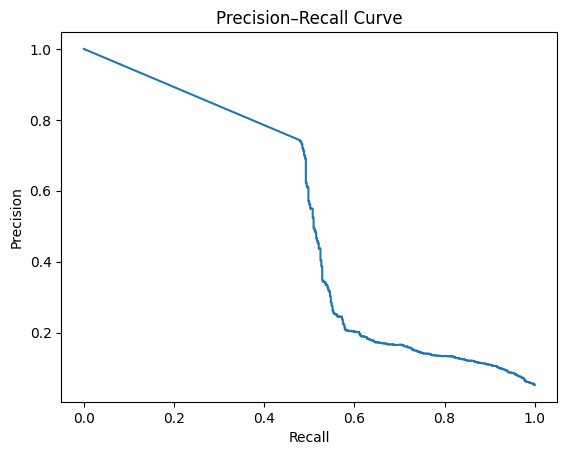

In [75]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.savefig("PRCurve")

In [76]:
m = SAGE(183, 128, 2, 5, 0.5)
m.load_state_dict(torch.load("GCN_best_f1_sage_model_weights.pth", weights_only=True))
m.to(device)
test(m, test_loader, NLLLoss(), full_report=True)

(0.7373417721518988,
 0.4446564885496183,
 0.5547619047619048,
 0.7675934510724629,
 0.9624987466158629,
 0.1277988744719543,
 0.2715915497392416)

In [77]:
m.eval()

all_y = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = m(batch.x, batch.edge_index)   # already softmaxed
        y = batch.y

        mask = y != 3
        if mask.sum() == 0:
            continue

        y_remapped = (y[mask] - 1).long()
        probs = out[mask][:, 0]   # positive class = 0

        all_y.extend(y_remapped.cpu())
        all_probs.extend(probs.cpu())
precision2, recall2, _ = precision_recall_curve(
    all_y,
    all_probs,
    pos_label=0
)

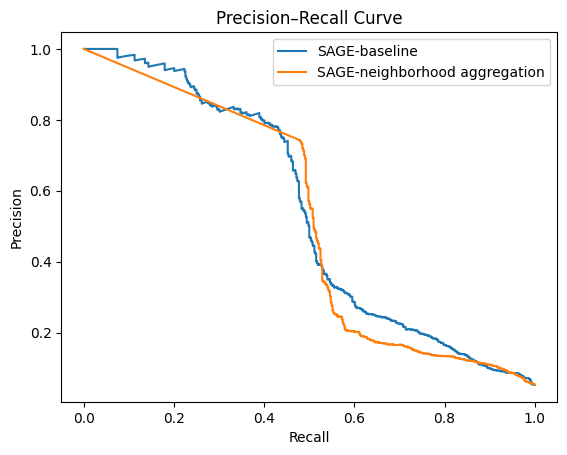

In [79]:
import matplotlib.pyplot as plt

plt.plot(recall2, precision2, label="SAGE-baseline")
plt.plot(recall, precision, label="SAGE-neighborhood aggregation")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.savefig("PRCurve")

Epoch: 0 | Train loss: 0.6474869132041932 | Validation f1: 0.0 | Validation loss: 0.4309964746236801
Epoch: 10 | Train loss: 0.4956589063008626 | Validation f1: 0.4220638363805392 | Validation loss: 0.3838852822780609
Epoch: 20 | Train loss: 0.4806989739338557 | Validation f1: 0.44933030073287844 | Validation loss: 0.373705780506134
Epoch: 30 | Train loss: 0.4666088620821635 | Validation f1: 0.49912536443148686 | Validation loss: 0.3464424341917038
Epoch: 40 | Train loss: 0.4619508147239685 | Validation f1: 0.5203761755485894 | Validation loss: 0.3325857684016228
Epoch: 50 | Train loss: 0.4610945542653402 | Validation f1: 0.5445614035087719 | Validation loss: 0.31262884885072706
Epoch: 60 | Train loss: 0.4467881838480631 | Validation f1: 0.5761538461538461 | Validation loss: 0.29365178346633913
Epoch: 70 | Train loss: 0.4394938449064891 | Validation f1: 0.5664388762338648 | Validation loss: 0.2981818154454231
Epoch: 80 | Train loss: 0.4350057790676753 | Validation f1: 0.576226248342907

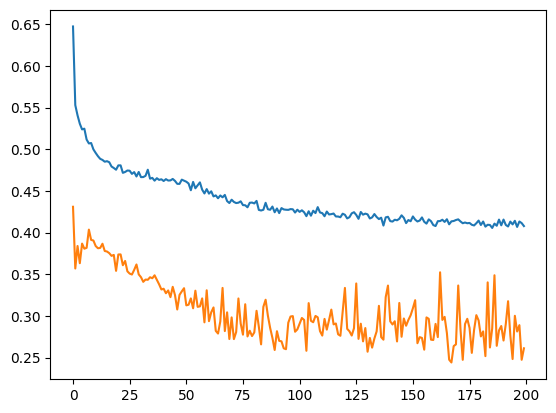

In [57]:
from torch_geometric.nn.conv import TransformerConv, GATConv

train_loader, val_loader, test_loader = load_data("batch")

np.random.seed(42)
torch.manual_seed(42)

args = {
    #MODEL PARAMETERS
    "input_dim": 183,
    "hidden_dim": 128,
    "output_dim": 2,
    "num_layers": 4,
    "conv_layer": GATConv, #Change this to try different convolutions
    "nonlinearity": torch.nn.functional.relu,
    "dropout": 0.5,
    "k_hops": 3,

    #TRAINING PARAMETERS
    "epochs": 200,
    "lr": 0.0001,
    "weight_decay": 0.01
}

model = train_model(Neighborhood_Aggregator, args, train_loader, val_loader, test_loader)

In [58]:
test(model, test_loader, loss_fn)

(0.4011627906976744, 0.2524079531431198)

# Trying to devise a general model

In [ ]:
class Neighborhood_Aggregator(torch.nn.Module):
    #Aggregator model which takes a conv_layer as a parameter, making model testing easier
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 output_dim,
                 num_layers,
                 conv_layer,
                 nonlinearity,
                 dropout,
                 normalize_adjacency=False,
                 custom_weighing=True,
                 k_hops = 2):
        super(Neighborhood_Aggregator, self).__init__()

        self.convs = torch.nn.ModuleList()   
        for i in range(num_layers):
            if num_layers == 1:
                self.convs.append(conv_layer(input_dim, output_dim))
            elif i == 0:
                self.convs.append(conv_layer(input_dim, hidden_dim))
            else:
                self.convs.append(conv_layer(hidden_dim, hidden_dim))

        self.lns = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)])

        #nonlinearity definition so we can mess around with functions other than ReLU
        self.nonlinearity = nonlinearity
        
        #final linear layer
        self.final = torch.nn.Linear(hidden_dim, output_dim)

        #adjacency weight
        self.adj_weights = torch.nn.ParameterList([torch.nn.Parameter(torch.tensor(np.random.rand(), requires_grad=True).cuda()) for _ in range(k_hops)])
        
        #softmax and dropout definition
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout
        self.normalize_adjacency = normalize_adjacency
        self.custom_weighing = custom_weighing
        self.k_hops = k_hops

    def forward(self, x, adj_t):
        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            if i < len(self.lns):
                x = self.lns[i](x) 
                x = self.nonlinearity(x)
                x = torch.nn.functional.dropout(x, self.dropout, training=self.training)

        A = to_dense_adj(adj_t).squeeze(0)#change edge index to adjacency matrix

        if self.normalize_adjacency:
            column_sums = A.sum(axis=0) + 1e-10
            A = A / column_sums[:, np.newaxis]

        #The main neighborhood aggregation logic
        elif self.custom_weighing:
            new_x = 0
            for i in range(self.k_hops):
                Adj = n_hop_neighbourhood(A, i)
                new_x += self.adj_weights[i] * x + (1 - self.adj_weights[i]) * Adj@x
            x = new_x

        else:
            x += A@x

        x = self.final(x) #Linear layer
        x = self.nonlinearity(x)
        x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
        
        return(self.softmax(x))